# Cis Effects Template

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cptac
from scipy import stats
from cnvutils import *
import statsmodels.stats.multitest
import cptac.utils

cptac warning: Your version of cptac (0.8.5) is out-of-date. Latest is 0.8.6. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-f280d4018ccd>, line 5)


## Stuff to fill out

In [2]:
cancer_types = {
    # Put here all the types of cancer that you want to look at. 
    'gbm': cptac.Gbm(),
    'luad': cptac.Luad(),
    'hnscc': cptac.Hnscc(),
    'ovarian': cptac.Ovarian(),
#     'colon': cptac.Colon(),
    'brca': cptac.Brca(),
    'lscc': cptac.Lscc()
}

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (<ipython-input-2-7914991718d5>, line 3)


cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-7914991718d5>, line 5)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-7914991718d5>, line 9)


In [3]:
# Enter the Chromosome and arm you are looking at. 
CHROMOSOME = '13'
ARM = 'q'

## Load all the data

In [4]:
proteomics = dict()
cnv = dict()
transcriptomics = dict()
for cancer_type in cancer_types:
    proteomics[cancer_type] = cancer_types[cancer_type].get_proteomics()
    cnv[cancer_type] = cancer_types[cancer_type].get_CNV()
    transcriptomics[cancer_type] = cancer_types[cancer_type].get_transcriptomics()

In [5]:
locations = get_gene_locations()

In [6]:
# Get just the genes that are in our event
subset_event = locations[(locations.chromosome == CHROMOSOME) & (locations.arm == ARM)]
genes = set(subset_event.index.get_level_values('Name'))

## Run Pearson Tests

In [7]:
def run_pearsons(protein, cnv_df, omics):
    try:
        if protein in cnv_df.columns.get_level_values('Name'):
            cnv_data = cnv_df.loc[:,cnv_df.columns.get_level_values('Name')==protein]
            cnv_column_name = cnv_data.columns.tolist()[0]
        else:
            return (np.nan, np.nan)
        omics_data = omics[protein]
        if isinstance(omics_data, pd.DataFrame):
            omics_data = omics.iloc[:,0]
        omics_data.name = 'omics'
        df = pd.concat([cnv_data, omics_data], axis=1)
        df.dropna(inplace=True)
        if len(df) < 3:
            return (np.nan,np.nan)
        return stats.pearsonr(df[cnv_column_name], df['omics'])
    except Exception as e:
        print(e)

### Proteomics

In [8]:
proteomics_results = None
for cancer_type in proteomics.keys():
    try:
        # We will use the index from the proteomics table. 
        proteomics_table = proteomics[cancer_type].copy()
        proteomics_table = proteomics_table.loc[:, proteomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(proteomics_table.columns, pd.MultiIndex):
            proteomics_table = proteomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = proteomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], proteomics_table)
            pvalues.append(p)
            rvalues.append(r)
        # Correct for multiple tests
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_proteomics': pval_corrected, f'{cancer_type}_rvalue_proteomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if proteomics_results is not None:
            proteomics_results = proteomics_results.join(temp, how='outer')
        else:
            proteomics_results = temp
    except Exception as e:
        print(e)

In [9]:
proteomics_results

,gbm_pvalue_proteomics,gbm_rvalue_proteomics,luad_pvalue_proteomics,luad_rvalue_proteomics,hnscc_pvalue_proteomics,hnscc_rvalue_proteomics,ovarian_pvalue_proteomics,ovarian_rvalue_proteomics,brca_pvalue_proteomics,brca_rvalue_proteomics,lscc_pvalue_proteomics,lscc_rvalue_proteomics
Name,,,,,,,,,,,,
ABCC4,0.013258,0.279427,2.086799e-01,0.175173,0.768260,-0.062150,0.106614,0.213996,8.044826e-01,0.029280,1.336977e-01,0.169880
ABCC4,0.013258,0.279427,2.086799e-01,0.175173,0.768260,-0.062150,0.106614,0.213996,8.044826e-01,0.029280,1.336977e-01,0.169880
ABHD13,0.000004,0.557709,9.615543e-03,0.277260,0.166116,0.176825,NaN,NaN,7.124663e-02,0.225200,6.961829e-05,0.419908
ADPRHL1,0.762991,0.043658,NaN,NaN,0.286714,0.123154,0.273434,0.593523,NaN,NaN,NaN,NaN
AKAP11,0.000766,0.367302,8.212086e-04,0.345522,0.372690,0.104527,0.386445,0.132982,2.377942e-09,0.540107,1.146291e-04,0.392060
...,...,...,...,...,...,...,...,...,...,...,...,...
ZC3H13,0.657184,0.061470,5.791655e-02,0.215815,0.827817,0.027723,0.543324,0.092629,2.122459e-01,0.129465,5.573898e-02,0.212207
ZDHHC20,0.002397,0.334825,5.150861e-07,0.489099,0.012952,0.269476,0.008293,0.327040,6.037409e-04,0.339234,1.947122e-06,0.467044
ZIC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.871202e-01,-0.005253,NaN,NaN


### Transcriptomics

In [10]:
transcriptomics_results = None
for cancer_type in transcriptomics.keys():
    try:
        # We will use the index from the proteomics table. 
        transcriptomics_table = transcriptomics[cancer_type].copy()
        transcriptomics_table = transcriptomics_table.loc[:, transcriptomics_table.columns.get_level_values('Name').isin(genes)]
        if isinstance(transcriptomics_table.columns, pd.MultiIndex):
            transcriptomics_table = transcriptomics_table.droplevel('Database_ID', axis=1)
        pvalues = list()
        rvalues = list()
        index = transcriptomics_table.columns.get_level_values('Name').tolist()
        for protein in index:
            r, p = run_pearsons(protein, cnv[cancer_type], transcriptomics_table)
            pvalues.append(p)
            rvalues.append(r)
        pvalues = np.array(pvalues)
        mask = np.isfinite(pvalues)
        pval_corrected = np.empty(len(pvalues))
        pval_corrected.fill(np.nan)
        pval_corrected[mask] = statsmodels.stats.multitest.multipletests(pvals=list(pvalues[mask]), alpha=0.05, method='fdr_bh')[1]
        temp = pd.DataFrame(data={f'{cancer_type}_pvalue_transcriptomics': pval_corrected, f'{cancer_type}_rvalue_transcriptomics': rvalues}, index=index)
        temp.index.name = 'Name'
        if transcriptomics_results is not None:
            transcriptomics_results = transcriptomics_results.join(temp, how='outer')
        else:
            transcriptomics_results = temp
    except Exception as e:
        print(e)

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\

C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\chels\anaconda3\envs\notebooks\lib\site-packages\scipy\

In [11]:
transcriptomics_results

,gbm_pvalue_transcriptomics,gbm_rvalue_transcriptomics,luad_pvalue_transcriptomics,luad_rvalue_transcriptomics,hnscc_pvalue_transcriptomics,hnscc_rvalue_transcriptomics,ovarian_pvalue_transcriptomics,ovarian_rvalue_transcriptomics,brca_pvalue_transcriptomics,brca_rvalue_transcriptomics,lscc_pvalue_transcriptomics,lscc_rvalue_transcriptomics
Name,,,,,,,,,,,,
ABCC4,3.045370e-03,0.315770,9.973104e-03,0.260263,3.322244e-05,0.412969,2.735255e-02,0.239276,1.124885e-01,0.162427,1.313978e-02,0.255648
ABHD13,2.883884e-04,0.377955,2.255125e-17,0.717202,1.627509e-16,0.710907,1.564540e-07,0.517625,5.605954e-11,0.569401,7.329816e-16,0.695439
AC000403.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACOD1,NaN,NaN,8.287071e-02,0.184202,3.297714e-02,0.234697,NaN,NaN,NaN,NaN,7.557110e-01,-0.037677
ADPRHL1,4.607645e-02,0.221678,2.836710e-03,0.298862,8.551880e-03,0.280304,NaN,NaN,6.777670e-03,0.262087,3.074482e-12,0.625091
...,...,...,...,...,...,...,...,...,...,...,...,...
ZIC5,7.509386e-02,0.199476,4.196574e-01,-0.115768,6.806908e-01,0.053697,6.709029e-01,0.053645,7.906016e-01,0.050880,2.764032e-02,0.233763
ZMYM2,7.779462e-09,0.564305,3.024229e-12,0.618124,4.519499e-10,0.577215,1.031659e-08,0.557103,2.765076e-08,0.495698,7.331667e-17,0.711746
ZMYM5,1.173855e-11,0.640202,1.751372e-16,0.701689,1.709387e-11,0.612740,NaN,NaN,1.000822e-05,0.406892,3.379840e-14,0.665652


## Create Graphs

In [12]:
# Join the graphs
all_results = transcriptomics_results.join(proteomics_results)

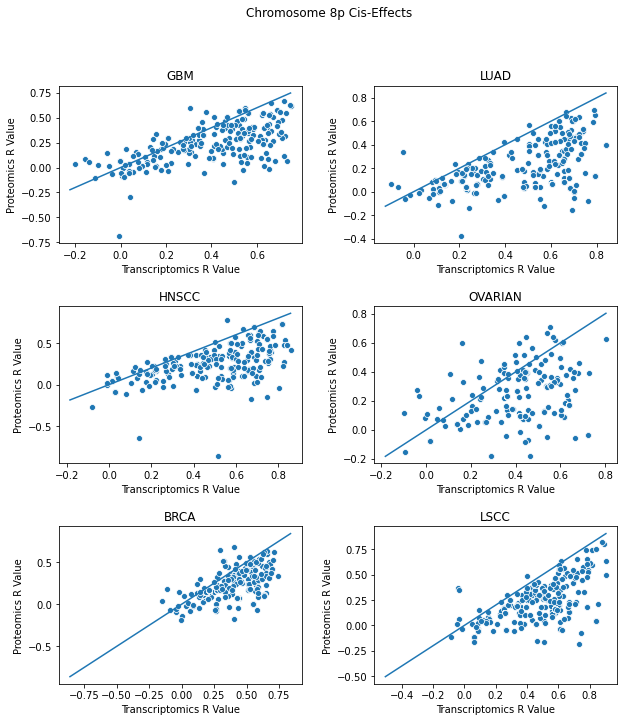

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=(10,11))
fig.suptitle("Chromosome 8p Cis-Effects")
count = 0
for cancer_type in proteomics.keys():
    sns.scatterplot(x=f'{cancer_type}_rvalue_transcriptomics', y=f'{cancer_type}_rvalue_proteomics', data=all_results, ax=axs[count//2][count%2])
    axs[count//2][count%2].set_title(cancer_type.upper())
    axs[count//2][count%2].set_xlabel("Transcriptomics R Value")
    axs[count//2][count%2].set_ylabel("Proteomics R Value")
    min_val = np.min(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    max_val = np.max(all_results[f'{cancer_type}_rvalue_transcriptomics'])
    axs[count//2][count%2].plot([min_val,max_val], [min_val,max_val])
    count += 1
plt.subplots_adjust(hspace=0.4, wspace=0.3)